## Pemodelan prediksi Cool and Warm by Season menggunakan RNN

##### 50:50

In [1]:
# Mengimport Pustaka yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
import itertools
import warnings
warnings.filterwarnings('ignore')

### Data Loading

In [2]:
df=pd.read_excel('Data c&w.xlsx')

In [3]:
df.tail()

,Year,DJF,JFM,FMA,MAM,AMJ,MJJ,JJA,JAS,ASO,SON,OND,NDJ
70,2020,0.5,0.5,0.4,0.2,-0.1,-0.3,-0.4,-0.6,-0.9,-1.2,-1.3,-1.2
71,2021,-1.0,-0.9,-0.8,-0.7,-0.5,-0.4,-0.4,-0.5,-0.7,-0.8,-1.0,-1.0
72,2022,-1.0,-0.9,-1.0,-1.1,-1.0,-0.9,-0.8,-0.9,-1.0,-1.0,-0.9,-0.8
73,2023,-0.7,-0.4,-0.1,0.2,0.5,0.8,1.1,1.3,1.6,1.8,1.9,2.0
74,2024,1.8,1.5,1.1,0.7,0.4,0.2,0.0,-0.1,NaN,NaN,NaN,NaN


##### Data Cleaning

In [4]:
df.dropna(inplace=True)

In [5]:
df.tail()

,Year,DJF,JFM,FMA,MAM,AMJ,MJJ,JJA,JAS,ASO,SON,OND,NDJ
69,2019,0.7,0.7,0.7,0.7,0.5,0.5,0.3,0.1,0.2,0.3,0.5,0.5
70,2020,0.5,0.5,0.4,0.2,-0.1,-0.3,-0.4,-0.6,-0.9,-1.2,-1.3,-1.2
71,2021,-1.0,-0.9,-0.8,-0.7,-0.5,-0.4,-0.4,-0.5,-0.7,-0.8,-1.0,-1.0
72,2022,-1.0,-0.9,-1.0,-1.1,-1.0,-0.9,-0.8,-0.9,-1.0,-1.0,-0.9,-0.8
73,2023,-0.7,-0.4,-0.1,0.2,0.5,0.8,1.1,1.3,1.6,1.8,1.9,2.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74 entries, 0 to 73
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    74 non-null     int64  
 1   DJF     74 non-null     float64
 2   JFM     74 non-null     float64
 3   FMA     74 non-null     float64
 4   MAM     74 non-null     float64
 5   AMJ     74 non-null     float64
 6   MJJ     74 non-null     float64
 7   JJA     74 non-null     float64
 8   JAS     74 non-null     float64
 9   ASO     74 non-null     float64
 10  SON     74 non-null     float64
 11  OND     74 non-null     float64
 12  NDJ     74 non-null     float64
dtypes: float64(12), int64(1)
memory usage: 8.1 KB


In [7]:
df.set_index('Year', inplace = True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74 entries, 1950 to 2023
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DJF     74 non-null     float64
 1   JFM     74 non-null     float64
 2   FMA     74 non-null     float64
 3   MAM     74 non-null     float64
 4   AMJ     74 non-null     float64
 5   MJJ     74 non-null     float64
 6   JJA     74 non-null     float64
 7   JAS     74 non-null     float64
 8   ASO     74 non-null     float64
 9   SON     74 non-null     float64
 10  OND     74 non-null     float64
 11  NDJ     74 non-null     float64
dtypes: float64(12)
memory usage: 7.5 KB


##### Normalisasi Data

In [9]:
data1 = np.array([df])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data1.reshape(-1, 1))

In [10]:
# Membuat Sequence Data
def create_sequences(data1, seq_length):
    X, y = [], []
    for i in range(len(data1) - seq_length):
        X.append(data1[i:(i + seq_length)])
        y.append(data1[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Panjang sequence
X, y = create_sequences(scaled_data, seq_length)

In [11]:
# Splitt data training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

##### Pendefinisian Model RNN

In [12]:
model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

In [13]:
# Compile model
model.compile(optimizer='adam', loss='mse')

In [14]:
# Training model
model.fit(X_train, y_train, 
          epochs=100, 
          batch_size=32, 
          validation_split=0.1,
          verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0920 - val_loss: 0.0384
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0275 - val_loss: 0.0145
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0128 - val_loss: 0.0095
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - val_loss: 0.0066
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - val_loss: 0.0049
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0057 - val_loss: 0.0038
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.

In [15]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3836e-04
Test Loss: 0.0009530706447549164


##### Prediksi model

In [16]:
predictions = model.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [17]:
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

In [18]:
r_squared = r2_score(y_test_actual, predictions)
print(f'R-squared: {r_squared}')

R-squared: 0.9703150257945243


##### Visualisasi Model

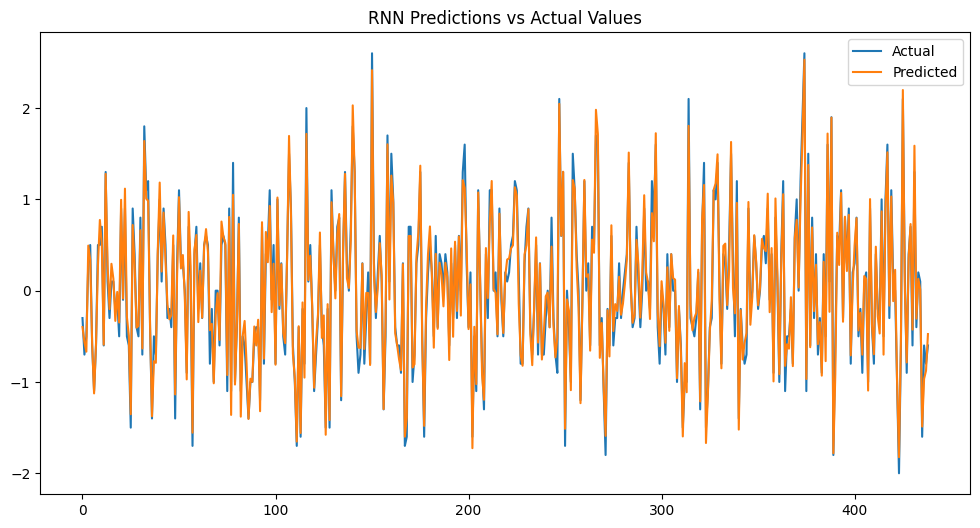

In [19]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('RNN Predictions vs Actual Values')
plt.show()